# GNNs

## mass into account

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv, GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies, generate_dataset_1gal, generate_scene_1gal
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

# Function to create edge weights based on mass difference
def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim=9, edge_dim=2,  node_enc_hidden = [128, 128], edge_enc_hidden = [128, 128], dec_hidden = [128, 128], gnn_dim=128, message_passing_steps=4, agg='add', output_dim=3):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.node_encoder = MLP([input_dim] + node_enc_hidden + [gnn_dim])
        self.edge_encoder = MLP([edge_dim] + edge_enc_hidden + [gnn_dim])
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GENConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr=agg, edge_dim=gnn_dim)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = MLP([gnn_dim] + dec_hidden + [output_dim])

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):
    # Extract features for each particle: [x, y, z, vx, vy, vz, mass]

    
    # Create edges based on radius
    edge_index = radius_graph(positions, r=radius)
    # for every node, connect it to top 2 biggest nodes
    '''
    biggest_nodes_index = torch.argsort(features[:, -1], descending=True)[:2]
    for i in range(features.shape[0]):
        if i not in biggest_nodes_index:
            edge_index = torch.cat((edge_index, torch.tensor([[i, biggest_nodes_index[0]], [i, biggest_nodes_index[1]]], dtype=torch.long)), 1)
            edge_index = torch.cat((edge_index, torch.tensor([[biggest_nodes_index[0], i], [biggest_nodes_index[1], i]], dtype=torch.long)), 1)
    '''


    
    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data



  


/opt/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)
def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

In [3]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

In [4]:
# Initialize model and optimizer
import os
model = ParticleGNN()
# load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
#model.load_state_dict(torch.load('./models/'+sorted(os.listdir('models'), key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1], map_location=torch.device(device)))


In [5]:
torch.mps.empty_cache()

In [7]:
import gc
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

ROUNDS = 50
EPOCHS = 4
SCENES = 20 
WINDOW_SIZE = 0
N_BODIES = 100
BATCH_SIZE = 64
RADIUS = 1.0
CHECKPOINT = 5

try:
    last_model_id = sorted([int(x.split('.')[0].split('_')[-1]) for x in os.listdir('models')])[-1]
    model.load_state_dict(torch.load(f'./models/particle_gnn_{last_model_id}.pth', map_location=torch.device(device)))
    print(f'Loaded model from ./models/particle_gnn_{last_model_id}.pth')
except:
    print('No model found, training from scratch')
    last_model_id = -1

# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_1gal(n_scenes=SCENES, window_size=WINDOW_SIZE, particles=N_BODIES),
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data[0], RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            del data
            #torch.cuda.empty_cache()
            torch.mps.empty_cache()
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del graphs, dataloader
    #torch.cuda.empty_cache()
    torch.mps.empty_cache()
    gc.collect()
    if (r+1) % CHECKPOINT == 0:
        print('Saving model...')
        torch.save(model.state_dict(), f'./models/particle_gnn_{last_model_id}.pth')
        last_model_id += 1
    







/var/folders/80/6r8bxtmd43bgpqvzbwvlm7nm0000gn/T/ipykernel_1710/4290739414.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./models/p

Loaded model from ./models/particle_gnn_1.pth
--- Round 0 ---
Generating dataset with 20 scenes...


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Converting to graphs...


100%|██████████| 19520/19520 [00:07<00:00, 2693.42it/s]


Training...
Epoch 1


100%|██████████| 305/305 [02:36<00:00,  1.95it/s]


Epoch 1, Loss: 0.6467193365097046
Epoch 2


100%|██████████| 305/305 [02:09<00:00,  2.35it/s]


Epoch 2, Loss: 0.4593956172466278
Epoch 3


100%|██████████| 305/305 [02:09<00:00,  2.36it/s]


Epoch 3, Loss: 0.41760945320129395
Epoch 4


100%|██████████| 305/305 [02:09<00:00,  2.36it/s]


Epoch 4, Loss: 0.3908405900001526
--- Round 1 ---
Generating dataset with 20 scenes...


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Converting to graphs...


100%|██████████| 19520/19520 [00:07<00:00, 2521.81it/s]


Training...
Epoch 1


100%|██████████| 305/305 [02:28<00:00,  2.06it/s]


Epoch 1, Loss: 0.5141544938087463
Epoch 2


100%|██████████| 305/305 [02:10<00:00,  2.34it/s]


Epoch 2, Loss: 0.4021921753883362
Epoch 3


100%|██████████| 305/305 [02:10<00:00,  2.34it/s]


Epoch 3, Loss: 0.3698703348636627
Epoch 4


100%|██████████| 305/305 [02:09<00:00,  2.36it/s]


Epoch 4, Loss: 0.34818410873413086
--- Round 2 ---
Generating dataset with 20 scenes...


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Converting to graphs...


100%|██████████| 19520/19520 [00:07<00:00, 2468.35it/s]


Training...
Epoch 1


100%|██████████| 305/305 [02:36<00:00,  1.95it/s]


Epoch 1, Loss: 0.446368545293808
Epoch 2


100%|██████████| 305/305 [02:11<00:00,  2.32it/s]


Epoch 2, Loss: 0.37100306153297424
Epoch 3


100%|██████████| 305/305 [02:09<00:00,  2.35it/s]


Epoch 3, Loss: 0.34546637535095215
Epoch 4


  4%|▍         | 12/305 [00:05<02:14,  2.18it/s]


KeyboardInterrupt: 

Simulation time: 10.03s
Prediction time: 25.85s


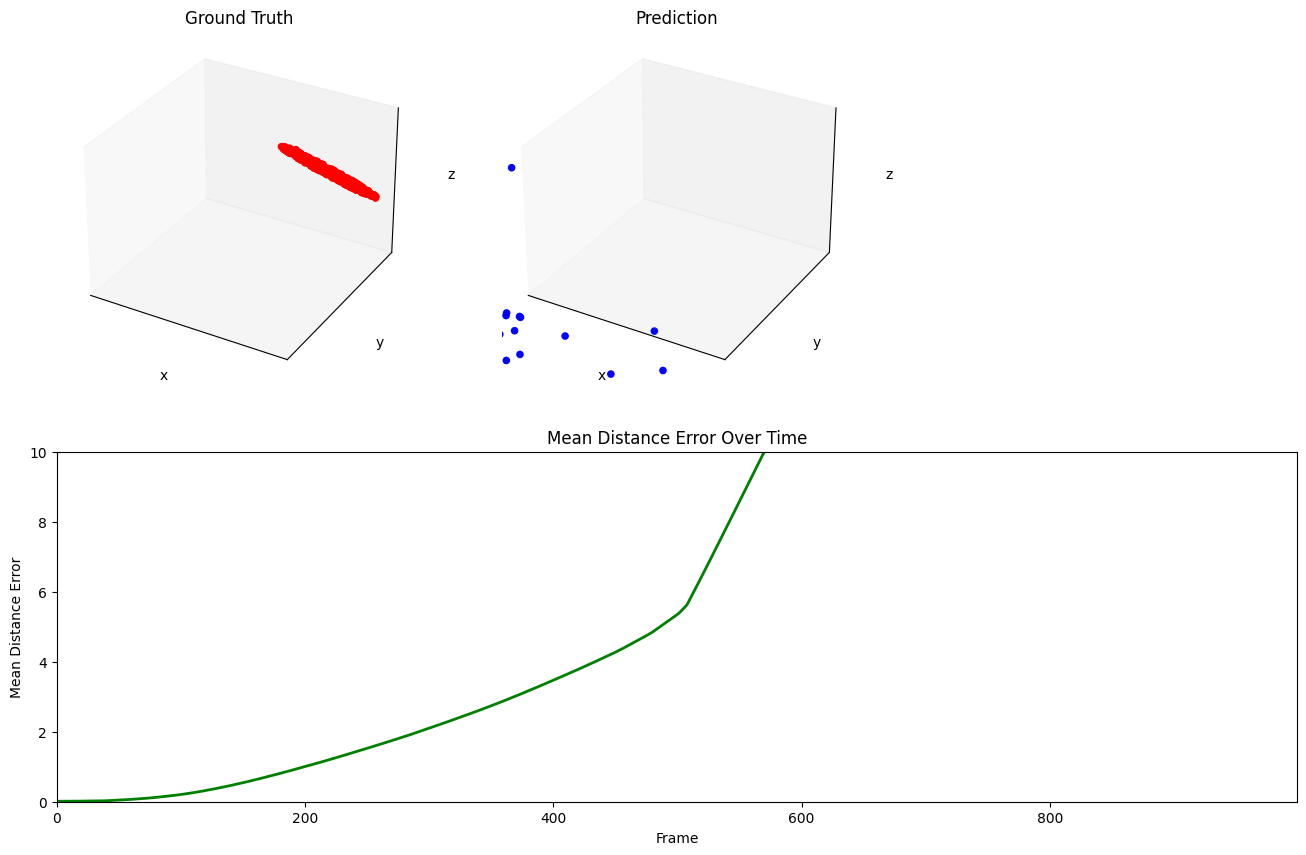

In [11]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.5):

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            if np.random.rand() < model_percentage:
                out = model(graph_data)
                acc = out.cpu().numpy()
            else:
                acc = sim_accelerations(positions.numpy(), masses.numpy())
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_scene(scene, pos_pred):
    # Create a 2D animation with a line plot below
    fig = plt.figure(figsize=(16, 10))

    # 3D scatter plot for Ground Truth
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')

    # 3D scatter plot for Prediction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')

    # Line plot for mean distance error over time
    ax3 = fig.add_subplot(212)
    ax3.set_xlim(0, len(pos_pred) - 1)
    ax3.set_ylim(0, 10)
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Mean Distance Error')
    ax3.set_title('Mean Distance Error Over Time')
    line, = ax3.plot([], [], color='g', lw=2)

    # Prepare the data
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2], c='r')
    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2], c='b')

    # Calculate mean distances for each frame
    mean_distance_per_step = [
        mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item()
        for i in range(len(pos_pred))
    ]

    # Update function for animation
    def update(frame):
        # Update 3D scatter plots
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2])
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2])

        # Update line plot with error values up to current frame
        line.set_data(np.arange(frame + 1), mean_distance_per_step[:frame + 1])
        
        return scat1, scat2, line

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)

    return anim, mean_distance_per_step



import time

start_sim = time.time()
scene = generate_scene_1gal(particles=500)
end_sim = time.time()
print(f'Simulation time: {end_sim - start_sim:.2f}s')
start_pred = time.time()
pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.1)
end_pred = time.time()
print(f'Prediction time: {end_pred - start_pred:.2f}s')
ani, mean_dist = animate_scene(scene, pos_pred)
HTML(ani.to_html5_video())